In [1]:
%matplotlib inline

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from detrend_func import detrend_func
from window_func import main as window_func

import dask
from distributed import Client, LocalCluster
import dask.array as da

import xarray as xr

In [2]:
# create a Dask Distributed cluster with one processor and as many
# threads as cores
cluster = LocalCluster(n_workers=1)
client = Client(cluster)

### Define constants to be used

In [3]:
dx = 5000. # meters
dy = 5000. # meters
dt = 1 # in days
H = [350.0, 750.0, 2900.0]  # meters
Htot = H[0] + H[1] + H[2]
f0 = 9.37456*(10**(-5)) #1/s (Coriolis parameter)
g = [.015, .0075]
delta_ek = 2. # meters
alpha_bc = 0.2 # nondimensional mixed boundary condition for OCEAN
gamma = 0.5*alpha_bc + 1 # nondimensional number for ease of calculation

In [4]:
tile_size = 100

#### RUN ONCE ONLY

#### ran on raijin with 32gb node. Takes about 70-80s per iteration

"""
indatadir = '/g/data1/v45/pm2987/Spunup'
outdatadir = '/g/data1/v45/jm0634/paige/Spunup_T'

for ncfile in ncfiles:
    outncfile = ncfile.replace(indatadir, outdatadir)
    outdir = os.path.dirname(outncfile)
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    if os.path.exists(outncfile):
        continue
        
    ds = xr.open_dataset(ncfile)\
           .isel(time=slice(None,-1)) # remove last time value since it repeated at the
                                      # start of each output file
    ds = ds.transpose('zi', 'z', 'yp', 'xp', 'time')
    
    encoding = { 'p'    : {'chunksizes': [1, 100, 100, 365]},
                 'q'    : {'chunksizes': [1, 100, 100, 365]},
                 'h'    : {'chunksizes': [1, 100, 100, 365]},
                 'taux' : {'chunksizes': [100, 100, 365]},
                 'tauy' : {'chunksizes': [100, 100, 365]},              
                 'e'    : {'chunksizes': [100, 100, 365]},
               }
    for v in encoding:
        encoding[v].update({'complevel': 0, 
                            'contiguous': False,
                            'dtype': np.dtype('float32'),
                            'source': ncfile,
                            'zlib': False})
    
    ds.to_netcdf(outncfile, engine='netcdf4', format='NETCDF4', encoding=encoding)
    del ds
"""

In [13]:
datadir = '/g/data1/v45/jm0634/paige/Spunup_T'

#ncfiles = sorted(glob(os.path.join(datadir, 'output*/ocpo.nc'))) # for all files
#ncfiles = sorted(glob(os.path.join(datadir, 'output013/ocpo.nc')))
ncfiles = sorted(glob(os.path.join(datadir, 'output01*/ocpo.nc')))

Construct a DataArray of all output files (takes a few seconds)

In [14]:
chunks = {'xp': tile_size, 'yp': tile_size, 
          'time':365, 'z':1, 'zi':1}

datasets = [xr.open_dataset(fn, 
                            chunks=chunks)
            for fn in ncfiles]

dsx = xr.concat(datasets, dim='time', coords='all')

### KE

$$
\frac{H_1}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_1}^* 
\widehat{J(\nabla_H^2 p_1,p_1)}\right]
+ \frac{H_2}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_2}^* 
\widehat{J(\nabla_H^2 p_2, p_2)}\right]
+\frac{H_3}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_3}^* 
\widehat{J(\nabla_H^2 p_3, p_3)}\right]
$$

In [15]:
def calc_KE(dsx, tile_index, z=0):
    
    # select variables
    p = dsx.p.isel(z=z)

    ix, iy = tile_index
    p = p.isel(yp=slice(max(iy*tile_size-2,0), (iy+1)*tile_size+2),
               xp=slice(max(ix*tile_size-2,0), (ix+1)*tile_size+2))
    xp = p.xp.values
    yp = p.yp.values
    time = p.time.values
    
    p = p.data
    
    # Concatenate two columns(?) on end for taking of derivatives (see handwritten notes on this)
    if ix==0:
        p = da.concatenate([(2/gamma)*p[:,slice(0,1),:] + ((gamma-2)/gamma)*p[:,slice(1,2),:], p], axis=1)
        p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[:,slice(1,2),:] - (4/(gamma**2))*p[:,slice(2,3),:] + ((gamma-alpha_bc)/gamma)*p[:,slice(3,4),:], p], axis=1)
    if iy==0:
        p = da.concatenate([(2/gamma)*p[slice(0,1),:,:] + ((gamma-2)/gamma)*p[slice(1,2),:,:], p], axis=0)
        p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[slice(1,2),:,:] - (4/(gamma**2))*p[slice(2,3),:,:] + ((gamma-alpha_bc)/gamma)*p[slice(3,4),:,:], p], axis=0)
    if ix==9:
        p = da.concatenate([(2/gamma)*p[:,slice(-1,None),:] + ((gamma-2)/gamma)*p[:,slice(-2,-1),:], p], axis=1)
        p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[:,slice(-2,-1),:] - (4/(gamma**2))*p[:,slice(-3,-2),:] + ((gamma-alpha_bc)/gamma)*p[:,slice(-4,-3),:], p], axis=1)
    if iy==9:
        p = da.concatenate([(2/gamma)*p[slice(-1,None),:,:] + ((gamma-2)/gamma)*p[slice(-2,-1),:,:], p], axis=0)
        p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[slice(-2,-1),:,:] - (4/(gamma**2))*p[slice(-3,-2),:,:] + ((gamma-alpha_bc)/gamma)*p[slice(-4,-3),:,:], p], axis=0)
    
    ny, nx, nt = p.shape
    p = p.rechunk(chunks={0: ny, 1: nx})
    #p = p.rechunk(chunks={0: tile_size + 6, 1:tile_size+6})
        
    def Jacobian(p):
        # stencil
        p_cc = p
        p_ac = np.roll(p_cc,  2, axis=0)
        p_bc = np.roll(p_cc,  1, axis=0)
        p_dc = np.roll(p_cc, -1, axis=0)
        p_ec = np.roll(p_cc, -2, axis=0)
    
        p_ca = np.roll(p_cc, -2, axis=1)
        p_cb = np.roll(p_cc, -1, axis=1)
        p_cd = np.roll(p_cc,  1, axis=1)
        p_ce = np.roll(p_cc,  2, axis=1)
    
        p_bb = np.roll(p_bc, -1, axis=1)
        p_bd = np.roll(p_bc,  1, axis=1)
        p_db = np.roll(p_dc, -1, axis=1)
        p_dd = np.roll(p_dc,  1, axis=1) 
        
        p_y = p_cd - p_cb
        p_x = p_bc - p_dc
        delp_x = (p_ce + p_bd + p_dd - 4*p_cd) - (p_ca + p_bb + p_db - 4*p_cb)
        delp_y = (p_bb + p_ac + p_bd - 4*p_bc) - (p_db + p_ec + p_dd - 4*p_dc)
    
        J = delp_x*p_y - delp_y*p_x
        return J

    J = p.map_blocks(Jacobian)
    J = J[2:tile_size+2, 2:tile_size+2, :]

    # Divide by gridsize^4 to get derivative
    J = (1./(4*(dx**4)))*J
    
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})

    p = p[2:tile_size+2, 2:tile_size+2, :]
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
        
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Execute fft function above
    Jhat = J.map_blocks(fft_block)
    phat = p.map_blocks(fft_block)
    
    Jhat = Jhat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})
    phat = phat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})

    KE = (H[z] / (f0**3 * Htot)) *(phat.conj()*Jhat).real

    KE = da.sum(KE, axis=(0,1))
    
    KE = KE.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    KE = xr.DataArray(KE, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return KE

In [9]:
calc_KE(dsx,(9,5))

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time


<xarray.DataArray (freq: 183)>
array([  1.504500e-05,  -9.651051e-06,  -8.335309e-05,   5.930954e-05,
         1.398217e-04,   2.139082e-05,   1.049782e-04,   1.280106e-04,
        -1.406203e-05,   2.595637e-07,  -1.621196e-05,   3.497320e-04,
         3.446355e-04,   2.416632e-04,   1.080085e-05,   1.243095e-05,
         4.782353e-04,   8.033285e-06,  -5.145648e-05,   1.857868e-06,
        -7.500349e-07,  -5.553840e-05,  -6.178666e-06,   2.223459e-05,
        -2.504284e-05,  -1.703196e-05,   3.714157e-06,   4.518765e-05,
        -1.741607e-05,   4.721367e-05,   4.745342e-05,  -3.306716e-07,
         3.553836e-07,   1.574615e-06,  -9.962734e-07,   9.131376e-06,
         2.841269e-06,   2.459877e-06,   8.548897e-07,  -7.986549e-08,
         2.227403e-06,   3.031163e-06,   5.916439e-06,   2.624593e-05,
         1.339777e-05,  -9.046713e-06,   3.521813e-05,   2.869138e-04,
        -4.186734e-06,  -1.291037e-06,  -2.930018e-07,   2.215649e-06,
         3.053658e-07,  -3.277423e-06,   3.082

### PE


$$
\frac{1}{f_0 H_{tot}} \frac{1}{g_1'}  \mathrm{Re}  \left[ \widehat{(p_2 - p_1)}^* \widehat{J( p_1,p_2)} \right]
+ \frac{1}{f_0 H_{tot}} \frac{1}{g_2'}  \mathrm{Re}  \left[ \widehat{(p_3 - p_2)}^* \widehat{J( p_2,p_3)} \right]
$$


In [64]:
def calc_PE(dsx, tile_index, z=0):
    
    # select variables
    p1 = dsx.p.isel(z=z)
    p2 = dsx.p.isel(z=z+1)
        
    ## Try detrend and window at start of code for comparison
    #def taper(p):
    #    p = detrend_func(p,'time')
    #    p = window_func(p,'time')
    #    return p
    
    #p1 = p1.map_blocks(taper)
    #p2 = p2.map_blocks(taper)
    
    # work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    p2 = p2.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))

    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data
    
    if ix==0:
        p1 = da.concatenate([(2/gamma)*p1[:,slice(0,1),:] + ((gamma-2)/gamma)*p1[:,slice(1,2),:], p1], axis=1)
        p2 = da.concatenate([(2/gamma)*p2[:,slice(0,1),:] + ((gamma-2)/gamma)*p2[:,slice(1,2),:], p2], axis=1)
    if iy==0:
        p1 = da.concatenate([(2/gamma)*p1[slice(0,1),:,:] + ((gamma-2)/gamma)*p1[slice(1,2),:,:], p1], axis=0)
        p2 = da.concatenate([(2/gamma)*p2[slice(0,1),:,:] + ((gamma-2)/gamma)*p2[slice(1,2),:,:], p2], axis=0)
    if ix==9:
        p1 = da.concatenate([(2/gamma)*p1[:,slice(-1,None),:] + ((gamma-2)/gamma)*p1[:,slice(-2,-1),:], p1], axis=1)
        p2 = da.concatenate([(2/gamma)*p2[:,slice(-1,None),:] + ((gamma-2)/gamma)*p2[:,slice(-2,-1),:], p2], axis=1)
    if iy==9:
        p1 = da.concatenate([(2/gamma)*p1[slice(-1,None),:,:] + ((gamma-2)/gamma)*p1[slice(-2,-1),:,:], p1], axis=0)
        p2 = da.concatenate([(2/gamma)*p2[slice(-1,None),:,:] + ((gamma-2)/gamma)*p2[slice(-2,-1),:,:], p2], axis=0)
        
    ny, nx, nt = p1.shape
    p1 = p1.rechunk(chunks={0: ny, 1: nx})
    p2 = p2.rechunk(chunks={0: ny, 1: nx})

    def Derivative(p, axis):
        p_right = np.roll(p, 1, axis=axis)
        p_left = np.roll(p, -1, axis=axis)
        dp = p_right - p_left
        return dp
        
    Derivative_x = lambda p: Derivative(p, 1)
    Derivative_y = lambda p: Derivative(p, 0)
    
    p1x = p1.map_blocks(Derivative_x)
    p1y = p1.map_blocks(Derivative_y)
    p2x = p2.map_blocks(Derivative_x)
    p2y = p2.map_blocks(Derivative_y)

    J = p1x*p2y - p1y*p2x
    
    J = J[1:tile_size+1, 1:tile_size+1, :]
    
    #ds = da.ones(J.shape, chunks=J.chunks)*4*(dx**2)
        
    # divide needed for derivatives
    #J = J / ds
    J = J/(4*(dx**2))
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    pdiff = p2 - p1
    pdiff = pdiff[1:tile_size+1, 1:tile_size+1, :]
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 
                                  1: tile_size/10, 
                                  2: 365*100})
    
    # Execute fft function above
    Jhat = J.map_blocks(fft_block)
    pdiffhat = pdiff.map_blocks(fft_block)
    
    #pdiffhat = da.fft.rfft(pdiff, axis=2)
    Jhat = Jhat.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})
    pdiffhat = pdiffhat.rechunk(chunks={0: tile_size, 
                                        1: tile_size, 
                                        2: 365})
    
    PE = (1 / (f0 * Htot)*(1/g[0]))*(pdiffhat.conj()*Jhat).real

    PE = da.sum(PE, axis=(0,1))
    
    PE = PE.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    PE = xr.DataArray(PE,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    return PE

calc_PE(dsx, (0,6))

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time


<xarray.DataArray (freq: 1278)>
array([  1.027454e-08,  -4.921384e-09,  -2.034387e-07, ...,  -1.038194e-10,
        -4.105814e-11,   3.458233e-12])
Coordinates:
  * freq     (freq) float64 0.0 0.1429 0.2858 0.4287 0.5716 0.7145 0.8574 ...
    xp       float32 250.0
    yp       float32 3247.5

## Buoyancy

$$
\frac{1}{H_{tot}} \mathrm{Re} \left[ \widehat{(p_2 - p_1)}^* \widehat{e_1} \right]
$$


In [46]:
def calc_buoyancy(dsx, tile_index):
    # select variables
    p1 = dsx.p.isel(z=0)
    p2 = dsx.p.isel(z=1)
    e = dsx.e
    
    # work with DaskArrays
    ix, iy = tile_index
    p1 = p1.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    p2 = p2.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    e = e.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size))
    
    xp = p1.xp.values
    yp = p1.yp.values
    time = p1.time.values
    
    p1 = p1.data
    p2 = p2.data
    e = e.data
    
    pdiff = p2 - p1
    
        
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    e = e.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    pdiff = pdiff.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})

    # Execute fft function above
    ehat = e.map_blocks(fft_block)
    pdiffhat = pdiff.map_blocks(fft_block)
    
    e = e.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    pdiff = pdiff.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    buoyancy = (1 / Htot)*(pdiffhat.conj()*ehat).real

    buoyancy = da.sum(buoyancy, axis=(0,1))
    
    buoyancy = buoyancy.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    buoyancy = xr.DataArray(buoyancy,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return buoyancy

## Windstress

$$
\frac{1}{H_{tot}} \mathrm{Re} \left[ \widehat{p_1}^* \widehat{w_{ek}} \right]
$$

In [11]:
def calc_windstress(dsx, tile_index):
    # select variables
    p = dsx.p.isel(z=0) # dimensions: (y,x,time) = (lat,lon,time)
    taux = dsx.taux
    tauy = dsx.tauy
    
# work with DaskArrays
#   - Cut 100 piece chunks, with padding on edges for derivatives
    ix, iy = tile_index
    p = p.isel(yp=slice(max(iy*tile_size,0), (iy+1)*tile_size),
                 xp=slice(max(ix*tile_size,0), (ix+1)*tile_size))
    taux = taux.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    tauy = tauy.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    
    xp = p.xp.values
    yp = p.yp.values
    time = p.time.values
    
    # Put into numpy arrays (to access the data)
    p = p.data
    taux = taux.data 
    tauy = tauy.data
    
    # Concatenate rows/columns for taking of derivative
    if ix==0:
        taux = da.concatenate([taux[:,slice(0,1),:], taux], axis=1)
        tauy = da.concatenate([tauy[:,slice(0,1),:], tauy], axis=1)
    if iy==0:
        taux = da.concatenate([taux[slice(0,1),:,:], taux], axis=0)
        tauy = da.concatenate([tauy[slice(0,1),:,:], tauy], axis=0)
    if ix==9:
        taux = da.concatenate([taux, taux[:,slice(-1,None),:]], axis=1)
        tauy = da.concatenate([tauy, tauy[:,slice(-1,None),:]], axis=1)
    if iy==9:
        taux = da.concatenate([taux, taux[slice(-1,None),:,:]], axis=0)
        tauy = da.concatenate([tauy, tauy[slice(-1,None),:,:]], axis=0)
        
    ny, nx, nt = taux.shape
    taux = taux.rechunk(chunks={0: ny, 1: nx})
    tauy = tauy.rechunk(chunks={0: ny, 1: nx})

    def Derivative(tau, axis):
        tau_right = np.roll(tau, 1, axis=axis)
        tau_left = np.roll(tau, -1, axis=axis)
        dtau = tau_right - tau_left
        return dtau
        
    Derivative_x = lambda tau: Derivative(tau, 1)
    Derivative_y = lambda tau: Derivative(tau, 0)
    
    # Run the derivative function
    tauy_x = tauy.map_blocks(Derivative_x)
    taux_y = taux.map_blocks(Derivative_y)

    # Define Ekman velocity
    wek = (1./f0) * (tauy_x - taux_y)
    
    # Trim matrix down to desired size after derivative
    wek = wek[1:tile_size+1, 1:tile_size+1, :]
    
    # If at end edges, they are less than "tile_size" long and so need to shave ends
    if len(wek[1,:,1]) < tile_size:
        wek = wek[:,:-1,:]
    if len(wek[:,1,1]) < tile_size:
        wek = wek[:-1,:,:]
    
    # Construct ds: matrix of constants to divide by in taking of derivative
    ds = da.ones(wek.shape, chunks=wek.chunks)*2*dx
    if ix==0:
        ds = da.concatenate( [ ds[:,slice(0,1),:]/2, ds[:,1:,:] ], axis = 1)
    if iy==0:
        ds = da.concatenate( [ ds[slice(0,1),:,:]/2, ds[1:,:,:] ], axis = 0)
    if ix==9:
        ds = da.concatenate( [ ds[:,slice(-1,None),:]/2, ds[:,:-1,:] ], axis = 1)
    if iy==9:
        ds = da.concatenate( [ ds[slice(-1, None),:,:]/2, ds[:-1,:,:] ], axis = 0)
        
    # Divide needed for derivatives
    wek = wek / ds
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat

    # Rechunk arrays into even smaller chunks for fft calculation
    wek = wek.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    
    # Execute fft function above
    wekhat = wek.map_blocks(fft_block)
    phat = p.map_blocks(fft_block)
    
    wek = wek.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    p = p.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    windstress = (1 / Htot)*(phat.conj()*wekhat).real

    windstress = da.sum(windstress, axis=(0,1))
    
    windstress = windstress.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    windstress = xr.DataArray(windstress,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return windstress

In [8]:
%%time
windstress = calc_windstress(dsx,(1,0))

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
CPU times: user 2.53 s, sys: 95 ms, total: 2.63 s
Wall time: 4.63 s


### Bottom Drag

$$
\frac{-\delta _{ek}}{2 f_0 H_{tot}} \mathrm{Re} \left[  \widehat{p_3}^* 
\widehat{\nabla_H^2 p_3}\right]
$$

In [65]:
def calc_bottomDrag(dsx, tile_index):
    
    # select variables
    p = dsx.p.isel(z=2)
        
    ix, iy = tile_index
    p = p.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
               xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    xp = p.xp.values
    yp = p.yp.values
    time = p.time.values
    
    p = p.data
    
    if ix==0:
        p = da.concatenate([(2/gamma)*p[:,slice(0,1),:] + ((alpha_bc-gamma)/gamma)*p[:,slice(1,2),:], p], axis=1)
    if iy==0:
        p = da.concatenate([(2/gamma)*p[slice(0,1),:,:] + ((alpha_bc-gamma)/gamma)*p[slice(1,2),:,:], p], axis=0)
    if ix==9:
        p = da.concatenate([p, (2/gamma)*p[:,slice(-1,None),:] + ((alpha_bc-gamma)/gamma)*p[:,slice(-2,-1),:]], axis=1)
    if iy==9:
        p = da.concatenate([p, (2/gamma)*p[slice(-1,None),:,:] + ((alpha_bc-gamma)/gamma)*p[slice(-2,-1),:,:]], axis=0)
        
    ny, nx, nt = p.shape
    p = p.rechunk(chunks={0: ny, 1: nx})
    
    #p = p.rechunk(chunks={0: tile_size + 2, 1:tile_size+2})
        
    def del2(p):
        # stencil
        p_cc = p
        p_bc = np.roll(p_cc,  1, axis=0)
        p_dc = np.roll(p_cc, -1, axis=0)
        p_cb = np.roll(p_cc, -1, axis=1)
        p_cd = np.roll(p_cc,  1, axis=1)
        
        del2p = p_dc + p_cd + p_bc + p_cb - 4*p_cc

        return del2p

    del2p = p.map_blocks(del2)

    # TODO: handle boundary
    del2p = (1./(dx**2))*del2p
    
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Trim added edges and rechunk for faster FFT
    del2p = del2p[1:tile_size+1, 1:tile_size+1, :]
    del2p = del2p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    p = p[1:tile_size+1, 1:tile_size+1, :]
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: 365*100})
    
    # Execute fft function above
    del2phat = del2p.map_blocks(fft_block)
    phat = p.map_blocks(fft_block)
    
    del2phat = del2phat.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})
    phat = phat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})

    bottomDrag = (delta_ek / (2. * f0 * Htot)) *(phat.conj()*del2phat).real

    bottomDrag = da.sum(bottomDrag, axis=(0,1))
    
    bottomDrag = bottomDrag.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    bottomDrag = xr.DataArray(bottomDrag, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return bottomDrag

In [66]:
%%time
calc_bottomDrag(dsx,(0,9))

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
CPU times: user 1.09 s, sys: 100 ms, total: 1.19 s
Wall time: 4.41 s


<xarray.DataArray (freq: 1278)>
array([ -4.617422e-08,  -5.882387e-08,  -5.382522e-08, ...,  -1.204782e-12,
        -1.108629e-12,  -1.149207e-12])
Coordinates:
  * freq     (freq) float64 0.0 0.1429 0.2858 0.4287 0.5716 0.7145 0.8574 ...
    xp       float32 250.0
    yp       float32 4647.5

In [16]:
%%time
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range((961+tile_size+1)//(tile_size)) 
xi = range((961+tile_size+1)//(tile_size))

tile_indexes = list(product(*[yi, xi]))

KE1_sum = 0
KE2_sum = 0
KE3_sum = 0
results = []
buoyancy_sum = 0
PE1_sum = 0
PE2_sum = 0
windstress_sum = 0
bottomDrag_sum = 0
for tile_index in tile_indexes[:]:
    KE1 = calc_KE(dsx, tile_index, 0)
    KE2 = calc_KE(dsx, tile_index, 1)
    KE3 = calc_KE(dsx, tile_index, 2)
    #KE = KE1+KE2+KE3
    KE1_sum += KE1
    KE2_sum += KE2
    KE3_sum += KE3
    
    #PE1 = calc_PE(dsx, tile_index, 0)
    #PE2 = calc_PE(dsx, tile_index, 1)
    #PE = PE1 + PE2
    #PE1_sum += PE1
    #PE2_sum += PE2

    #windstress = calc_windstress(dsx,tile_index)
    #windstress_sum += windstress
    
    #buoyancy = calc_buoyancy(dsx, tile_index)
    #buoyancy_sum += buoyancy
    
    #bottomDrag = calc_bottomDrag(dsx,tile_index)
    #bottomDrag_sum += bottomDrag
    
    # Want to sum each buoyancy term, and divide by the total number of spatial points
    #results.append(buoyancy)
    #results.sum(buoyancy)
    
    #results.append(KE)
    
#buoyancy_avg = buoyancy_sum/(961*961)

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending i

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending i

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending i

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending i

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending i

Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending in time yay!
After time detrend  (1, 1, 1)
Making window in time
Detrending i

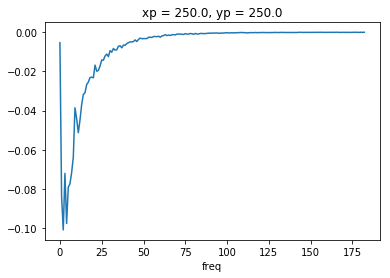

In [119]:
PE_sum.plot()

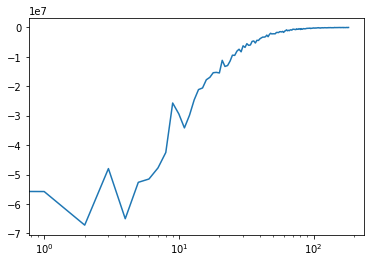

In [106]:
plt.figure()
plt.plot(PE_sum)
plt.xscale('log')

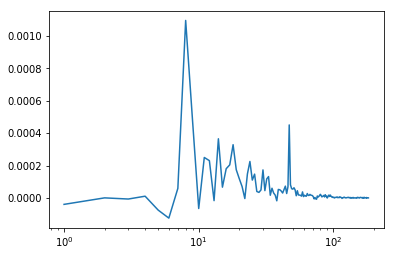

In [66]:
# Plot KE1

KE_sum_lineardetrend = KE_sum
np.save("TKE1_lineardetrend_output013",KE_sum_lineardetrend)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(KE_sum*ktiso)

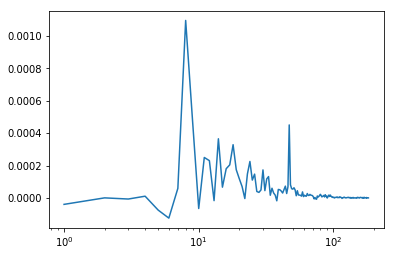

In [11]:
# Plot KE1 (not detrended/windowed)
ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(KE_sum*ktiso)

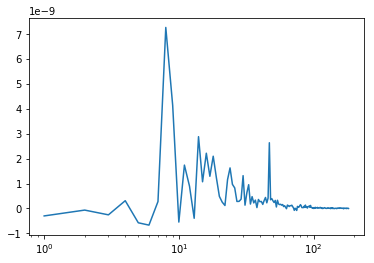

In [19]:
# Plot KE1 (with detrend and window before FFT)
ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(KE_sum*ktiso)

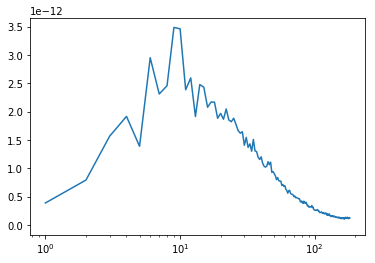

In [18]:
# Plot buoyancy (with detrend and window before FFT)
np.save("Tbuoyancy_output013",buoyancy_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(buoyancy_sum*ktiso)

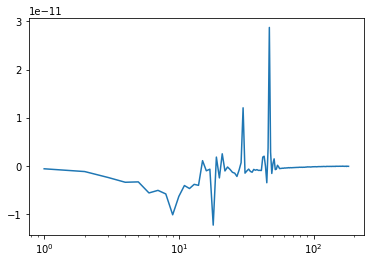

In [20]:
# Plot windstress (with detrend and window before FFT)
np.save("Twindstress_output013",windstress_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(365.0/2)+1)

plt.semilogx(windstress_sum*ktiso)

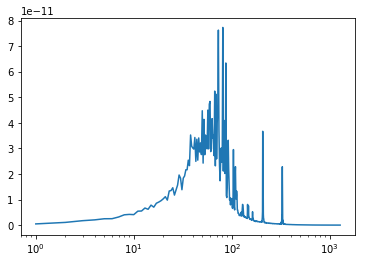

In [71]:
# Plot bottom drag (with detrend and window before FFT)
np.save("TbottomDrag_output013_019_newBC",bottomDrag_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(7*365.0/2)+1)

plt.semilogx(-bottomDrag_sum*ktiso)

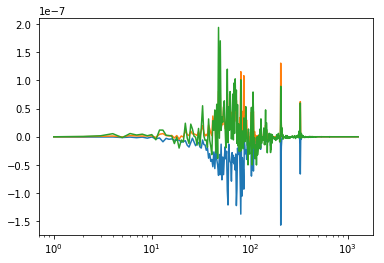

In [17]:
# Plot KE (with detrend and window before FFT)
np.save("TKE1_output013_019_newBC2_correctderiv",KE1_sum)
np.save("TKE2_output013_019_newBC2_correctderiv",KE2_sum)
np.save("TKE3_output013_019_newBC2_correctderiv",KE3_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(7*365.0/2)+1)

plt.semilogx(KE1_sum*ktiso)
plt.semilogx(KE2_sum*ktiso)
plt.semilogx(KE3_sum*ktiso)

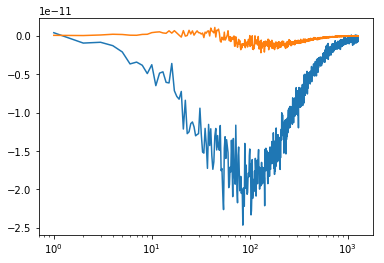

In [73]:
# Plot PE (with detrend and window before FFT)
np.save("TPE1_output013_019_newBC",PE1_sum)
np.save("TPE2_output013_019_newBC",PE2_sum)

ktiso = (2*np.pi/(365*24*60*60))*np.arange(0,np.floor(7*365.0/2)+1)

plt.semilogx(PE1_sum*ktiso)
plt.semilogx(PE2_sum*ktiso)